# UNDERSTANDING MODEL PREDICTIONS

In this notebook, we recall our original clustering, demonstrate its robustness and make use of it to understand the limitations of our RSA-based cluster label prediction models.

## IMPORTING NECESSARY PACKAGES

In [1]:
from fragsys_analysis import *

## READING INPUT DATA

In [2]:
main_dir = "./../"
results_dir = os.path.join(main_dir, "results")
figs_dir = os.path.join(main_dir, "figs")

In [27]:
UD_df = pd.read_pickle(os.path.join(results_dir, "UD_df.pkl"))
ann_pred_conf_df = pd.read_pickle(os.path.join(results_dir, "good_confidence_data.pkl"))
rsa_cluster_dict = load_pickle(os.path.join(results_dir, "rsa_cluster_dict.pkl"))
color_dict = {k:matplotlib.colors.to_hex(sample_colors[v-1]) for k, v in rsa_cluster_dict.items()}

blind = load_pickle(os.path.join(results_dir, "x_blind.pkl"))
ANN_wrong_preds = load_pickle(os.path.join(results_dir, "x_wrong_ANN.pkl"))
KNN_wrong_preds = load_pickle(os.path.join(results_dir, "x_wrong_KNN.pkl"))

In [28]:
ANN_wrong_preds # only 1 wrong prediction by ANN

['Q32ZE1_0_BS3']

In [26]:
KNN_wrong_preds #KNN accuracy is 100%

[]

## MDS REPRESENTATION COLOURED BY CLUSTER MEMBERSHIP

In [4]:
n = 2
mds_model = sklearn.manifold.MDS(n_components = n, random_state = 123,
    dissimilarity = 'precomputed', normalized_stress = False)
mds_fit = mds_model.fit(UD_df)  
mds_coords = mds_model.fit_transform(UD_df)

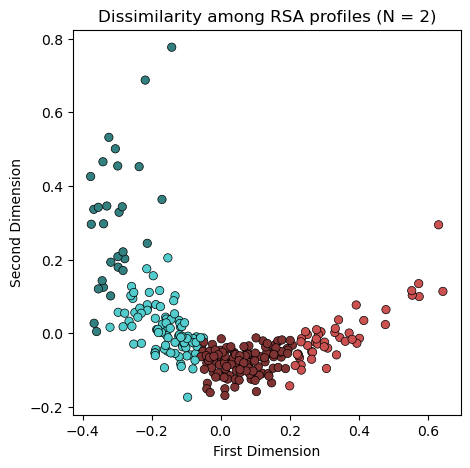

In [5]:
cols = list(color_dict.values())

plt.figure(figsize=(5, 5), dpi= 100)
plt.scatter(
        mds_coords[:,0],mds_coords[:,1],
        color = cols, edgecolors = "k",# s = 75,
        linewidth = 0.5, marker = "o"
        )
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('Dissimilarity among RSA profiles (N = {})'.format(n))

#plt.savefig(os.path.join(main_dir, "figs", "rsa_distrs_kmeans_reordered_n.png".format(n)))

plt.show()


In [6]:
mds_df = pd.DataFrame(mds_coords, columns = ["x", "y"])
mds_df.index = UD_df.index

## K-MEANS CLUSTERING STABILITY

In [103]:
randl = [random.randint(1, 10000000) for i in range(1000)]

In [105]:
len(set(randl))

1000

### CLUSTERING 1,000 TIMES WITH DIFFERENT SEEDS AND OBTAINING MEMBERSHIP

In [7]:
iii = 1000

In [213]:
K = 4
colss = sample_colors[:4]
kmeans_cluster_dicts = {}
kmeans_memberships = {}

for randi in randl[:iii]:
    
    kmeans = KMeans(n_clusters = K, random_state = randi, n_init = 10).fit(UD_df)

    kmeans_c_labs = list(kmeans.labels_)
    
    un_labs = list(set(kmeans_c_labs))

    kmeans_cluster_dicts[randi] = {UD_df.index.tolist()[i]: kmeans_c_labs[i] for i in range(len(kmeans_c_labs))}

    kmeans_memberships[randi] = {un_lab:[k for k, v in kmeans_cluster_dicts[randi].items() if v == un_lab] for un_lab in un_labs} # contains binding site cluter membership dictionary for each seed

In [217]:
len(kmeans_memberships)

1000

### GETTING CLUSTER CENTROIDS FOR EACH SEED

In [218]:
mds_centroids_dict = {}
for randi in randl[:iii]:
    mds_centroids_dict[randi] = {}
    for k, v in kmeans_memberships[randi].items():
        mds_df_clust = mds_df.loc[v,:]
        mds_centroids_dict[randi][k] = (mds_df_clust.x.mean(), mds_df_clust.y.mean()) # obtaining cluster centroids for each seed using the mds coordinates and cluster membership

### GETTING CENTROID DISTANCES FOR EACH SEED TO A REFERENCE SEED [0]

In [219]:
centroids_ref = mds_centroids_dict[randl[0]] # reference cluster centroids are from first seed
centroids_dist_dict = {}
for randi in randl[:iii]:
    centroids_sam = mds_centroids_dict[randi]
    centroids_dist_dict[randi] = {}
    for k1, v1 in centroids_sam.items():
        centroids_dist_dict[randi][k1] = {}
        for k2, v2 in centroids_ref.items():
            centroids_dist_dict[randi][k1][k2] = euclidean(centroids_sam[k1], centroids_ref[k2]) # dictionary containing cluster centroid distances to ref for each seed

### GETTING CLUSTER ID EQUIVALENCE BETWEEN DIFFERENT SEEDS

In [220]:
centroids_eq_dict = {}
for k, v in centroids_dist_dict.items():
    centroids_eq_dict[k] = {}
    for vk, vv in v.items():
        centroids_eq_dict[k][vk] = np.argmin(list(vv.values())) # dictionary indicating cluster equicalence to a reference seed

In [222]:
len(centroids_eq_dict)

1000

### GETTING NEW CLUSTER MEMBERSHIP RELEATIVE TO REFERENCE FOR ALL SEEDS

In [223]:
kmeans_cluster_dicts_new = {}
kmeans_cluster_dicts_new[randl[0]] = kmeans_cluster_dicts[randl[0]]
for randi in randl[:iii]:
    kmeans_cluster_dicts_new[randi] = {k: centroids_eq_dict[randi][v] for k, v in kmeans_cluster_dicts[randi].items()} # now cluster labels across all seeds refere to the same cluster

In [241]:
kmeans_seeds_df = pd.DataFrame.from_dict(kmeans_cluster_dicts_new, orient = "index")

In [246]:
kmeans_seeds_df.to_pickle(os.path.join(results_dir, "kmeans_seeds_df.pkl"))

### CALCULATING CLUSTER LABEL ASSIGNMENT STABILITY FOR EACH BINDING SITE

In [8]:
kmeans_seeds_df = pd.read_pickle(os.path.join(results_dir, "kmeans_seeds_df.pkl"))

In [9]:
stability_dict = {}
for col in kmeans_seeds_df.columns.tolist():
    un_vals = kmeans_seeds_df[col].unique().tolist()
    stability_dict[col] = max(kmeans_seeds_df[col].value_counts())/iii

In [10]:
len(stability_dict)

293

### 4 SITES THAT CHANGE LABEL DEPENDING ON RANDOM INITIALISATION OF K-MEANS CLUSTERING

In [11]:
{k: v for k, v in stability_dict.items() if v != 1.0}

{'P0C024_0_BS0': 0.689,
 'Q9UGL1_0_BS2': 0.955,
 'Q6B0I6_0_BS8': 0.955,
 'P11838_0_BS8': 0.689}

In [12]:
kmeans_seeds_df.loc[:, "P0C024_0_BS0"].T.value_counts()

3    689
0    311
Name: P0C024_0_BS0, dtype: int64

In [13]:
kmeans_seeds_df.loc[:, "Q9UGL1_0_BS2"].T.value_counts()

2    955
0     45
Name: Q9UGL1_0_BS2, dtype: int64

In [14]:
kmeans_seeds_df.loc[:, "Q6B0I6_0_BS8"].T.value_counts()

2    955
0     45
Name: Q6B0I6_0_BS8, dtype: int64

In [15]:
kmeans_seeds_df.loc[:, "P11838_0_BS8"].T.value_counts()

3    689
0    311
Name: P11838_0_BS8, dtype: int64

#### Labels of all seeds are the same based on reference clustering (first random seed)

In [44]:
cl_adhoc = list({k: sample_colors[v] for k, v in kmeans_seeds_df.loc[7533556,:].to_dict().items()}.values())

On reference:
- 0 --> 1
- 1 --> 3
- 2 --> 0
- 3 --> 2

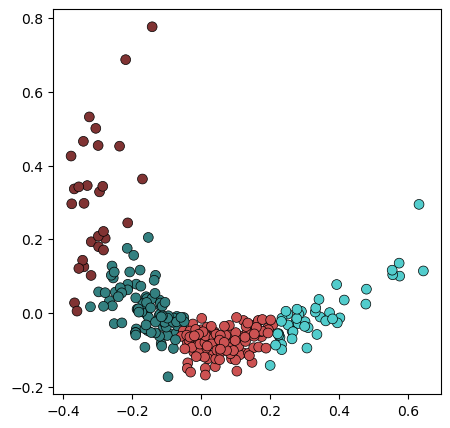

In [46]:
plt.figure(figsize = (5, 5), dpi = 100)
sc = plt.scatter(
            mds_coords[:,0],mds_coords[:,1],
            c = cl_adhoc, edgecolors = "k", s = 50,
            linewidth = 0.5, marker = "o"#, cmap = "cividis"
            )

In [16]:
round(100-100*(len({k: v for k, v in stability_dict.items() if v != 1.0})/len(stability_dict)),2)

98.63

In [ ]:
dump_pickle(stability_dict, os.path.join(results_dir, "kmeans_stability.pkl"))

### MDS REPRESENTATION COLOURED BY CLUSTERING STABILITY

In [18]:
cl = ["orangered" if 0 <= i < 1 else "cornsilk"  for i in stability_dict.values()]

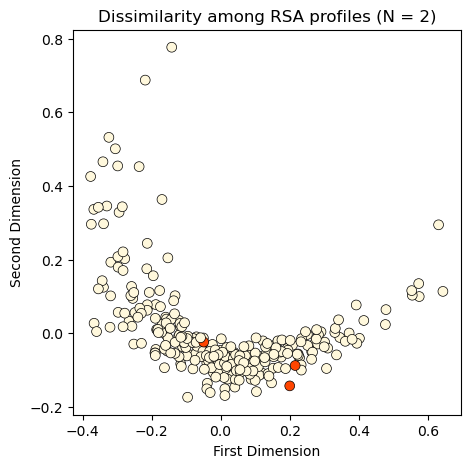

In [19]:
plt.figure(figsize = (5, 5), dpi = 100)
sc = plt.scatter(
            mds_coords[:,0],mds_coords[:,1],
            c = cl, edgecolors = "k", s = 50,
            linewidth = 0.5, marker = "o"#, cmap = "cividis"
            )

plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('Dissimilarity among RSA profiles (N = {})'.format(n))
#plt.savefig(os.path.join(figs_dir, "MDS_cluster_stability.png".format(n)))
plt.show()

## LOW-CONFIDENCE AND WRONG PREDICTIONS

In [20]:
print(UD_df.shape)
print(ann_pred_conf_df.shape)
print(len(blind))

(293, 293)
(2660, 4)
27


In [22]:
conf_vals = []
conf_vals_dict = {}
for bsid in UD_df.index.tolist():
    if bsid in ANN_wrong_preds:
        conf_vals.append(-1)
        conf_vals_dict[bsid] = -1
        continue
    elif bsid in KNN_wrong_preds: # never true, as there are not any KNN wrong preds
        conf_vals.append(-2)
        conf_vals_dict[bsid] = -2
        continue
    else:
        if bsid in blind:
            conf_vals.append(11)
            conf_vals_dict[bsid] = 11
            continue
    
        conf_bsid = ann_pred_conf_df[ann_pred_conf_df["id"] == bsid]["conf"].mean()
        conf_vals.append(conf_bsid)
        conf_vals_dict[bsid] = conf_bsid

In [23]:
cl = ["midnightblue" if 0 <= i < 4 else "orangered" if i == -1 else "red" if i == -2 else "limegreen" if i == 11  else "cornsilk" for i in conf_vals]

### MDS REPRESENTATION COLOURED BY PREDICTION CONFIDENCE/ACCURACY

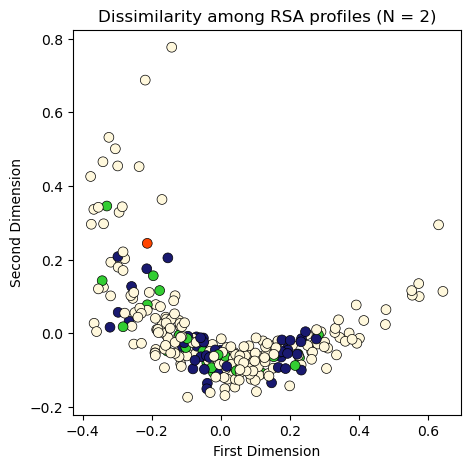

In [24]:
plt.figure(figsize=(5, 5), dpi = 100)
plt.scatter(
            mds_coords[:,0],mds_coords[:,1],
            c = cl, edgecolors = "k", s = 50,
            linewidth = 0.5, marker = "o"
            )
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('Dissimilarity among RSA profiles (N = {})'.format(n))
#plt.savefig(os.path.join(figs_dir, "MDS_wrong_ML_preds.png".format(n)))
plt.show()